## Setup

In [2]:
import pandas as pd
import numpy as np

print("✅ Libraries loaded!")

✅ Libraries loaded!


## Load Data

In [3]:
# Load the per-season QB data
df = pd.read_csv('qb_rankings_by_season.csv')

print(f"Loaded {len(df)} QB-seasons (2010-2025)")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSeasons: {sorted(df['season'].unique())}")

Loaded 677 QB-seasons (2010-2025)

Columns: ['passer_player_name', 'season', 'total_epa_per_play', 'cpoe_mean', 'sack_rate', 'yards_per_attempt', 'td_turnover_ratio', 'success_rate', 'completion_pct', 'pass_attempts', 'rushing_yards', 'rush_attempts', 'interceptions', 'fumbles_lost', 'total_plays', 'total_games']

Seasons: [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


## Define Rating System

### Philosophy:
- **Raw stats → Percentile ranks → Madden scale (0-99)**
- Use percentile-based approach so ratings reflect relative standing
- Elite players (99th percentile) get 99 rating
- Average players (50th percentile) get ~75 rating
- Poor players (10th percentile) get ~60 rating
- This matches Madden's distribution where most starters are 70-85

In [4]:
def percentile_to_madden(percentile):
    """
    Convert percentile rank (0-100) to Madden rating (0-99).
    
    Distribution:
    - 99th percentile → 99 rating (elite)
    - 90th percentile → 90 rating (very good)
    - 75th percentile → 80 rating (good starter)
    - 50th percentile → 75 rating (average starter)
    - 25th percentile → 70 rating (below average)
    - 10th percentile → 60 rating (backup)
    """
    if percentile >= 95:
        # Elite tier: 95-100 percentile → 95-99 rating
        return 95 + (percentile - 95) * 0.8
    elif percentile >= 75:
        # Good tier: 75-95 percentile → 85-95 rating
        return 85 + (percentile - 75) * 0.5
    elif percentile >= 50:
        # Average tier: 50-75 percentile → 75-85 rating
        return 75 + (percentile - 50) * 0.4
    elif percentile >= 25:
        # Below average: 25-50 percentile → 68-75 rating
        return 68 + (percentile - 25) * 0.28
    else:
        # Backup tier: 0-25 percentile → 50-68 rating
        return 50 + percentile * 0.72

# Test the function
print("Percentile → Madden Rating Examples:")
for pct in [99, 95, 90, 75, 50, 25, 10, 5]:
    print(f"  {pct}th percentile → {percentile_to_madden(pct):.0f} rating")

Percentile → Madden Rating Examples:
  99th percentile → 98 rating
  95th percentile → 95 rating
  90th percentile → 92 rating
  75th percentile → 85 rating
  50th percentile → 75 rating
  25th percentile → 68 rating
  10th percentile → 57 rating
  5th percentile → 54 rating


## Calculate Individual Ratings

For each dimension, we:
1. Calculate raw metric from stats
2. Convert to percentile rank (within all QB-seasons)
3. Apply Madden conversion formula

In [5]:
def calculate_ratings(df, season_filter=None, min_attempts=150):
    """
    Calculate Madden-style ratings for all QBs.
    
    Args:
        df: DataFrame with QB stats
        season_filter: If provided, filter to specific season(s)
        min_attempts: Minimum pass attempts to qualify (default 150)
    
    Returns:
        DataFrame with ratings
    """
    # Filter data
    if season_filter is not None:
        if isinstance(season_filter, (int, str)):
            data = df[df['season'] == int(season_filter)].copy()
        else:
            data = df[df['season'].isin(season_filter)].copy()
    else:
        data = df.copy()
    
    # Apply minimum attempts filter
    data = data[data['pass_attempts'] >= min_attempts].copy()
    
    print(f"Calculating ratings for {len(data)} qualified QB-seasons...")
    
    # 1. MOBILITY - Rush yards per game
    data['mobility_raw'] = data['rushing_yards'] / data['total_games']
    data['mobility_pct'] = data['mobility_raw'].rank(pct=True) * 100
    data['mobility_rating'] = data['mobility_pct'].apply(percentile_to_madden).round(0).astype(int)
    
    # 2. AGGRESSION - Yards per attempt (deep ball tendency)
    data['aggression_raw'] = data['yards_per_attempt']
    data['aggression_pct'] = data['aggression_raw'].rank(pct=True) * 100
    data['aggression_rating'] = data['aggression_pct'].apply(percentile_to_madden).round(0).astype(int)
    
    # 3. ACCURACY - CPOE (Completion % Over Expected)
    data['accuracy_raw'] = data['cpoe_mean']
    data['accuracy_pct'] = data['accuracy_raw'].rank(pct=True) * 100
    data['accuracy_rating'] = data['accuracy_pct'].apply(percentile_to_madden).round(0).astype(int)
    
    # 4. BALL SECURITY - Inverted turnover rate
    data['turnover_rate'] = ((data['interceptions'] + data['fumbles_lost']) / data['total_plays']) * 100
    # Lower turnover rate = better, so invert for percentile
    data['ball_security_pct'] = (100 - data['turnover_rate'].rank(pct=True) * 100)
    data['ball_security_rating'] = data['ball_security_pct'].apply(percentile_to_madden).round(0).astype(int)
    
    # 5. POCKET PRESENCE - Inverted sack rate
    # Lower sack rate = better, so invert for percentile
    data['pocket_presence_pct'] = (100 - data['sack_rate'].rank(pct=True) * 100)
    data['pocket_presence_rating'] = data['pocket_presence_pct'].apply(percentile_to_madden).round(0).astype(int)
    
    # 6. PLAYMAKING - EPA per play (overall value creation)
    # This is the "does this QB win plays?" dimension
    data['playmaking_raw'] = data['total_epa_per_play']
    data['playmaking_pct'] = data['playmaking_raw'].rank(pct=True) * 100
    data['playmaking_rating'] = data['playmaking_pct'].apply(percentile_to_madden).round(0).astype(int)
    
    # 7. OVERALL RATING - Using composite score model from Streamlit
    # Normalize key features to 0-100 scale
    feature_columns = ['total_epa_per_play', 'cpoe_mean', 'yards_per_attempt', 
                      'td_turnover_ratio', 'completion_pct']
    
    X_normalized = data[feature_columns].copy()
    for col in feature_columns:
        min_val = data[col].min()
        max_val = data[col].max()
        if max_val > min_val:
            X_normalized[col] = 100 * (data[col] - min_val) / (max_val - min_val)
        else:
            X_normalized[col] = 50
    
    # Invert sack_rate (lower is better)
    min_val = data['sack_rate'].min()
    max_val = data['sack_rate'].max()
    if max_val > min_val:
        X_normalized['sack_rate_inv'] = 100 - (100 * (data['sack_rate'] - min_val) / (max_val - min_val))
    else:
        X_normalized['sack_rate_inv'] = 50
    
    # Calculate composite score with feature weights from Streamlit
    feature_weights = {
        'total_epa_per_play': 0.25,
        'cpoe_mean': 0.15,
        'yards_per_attempt': 0.12,
        'td_turnover_ratio': 0.11,
        'completion_pct': 0.09,
        'sack_rate_inv': 0.05
    }
    
    data['composite_score'] = sum(
        X_normalized[col] * feature_weights[col] 
        for col in feature_weights.keys()
    )
    
    # Normalize composite score to Madden scale (50-99)
    min_score = data['composite_score'].min()
    max_score = data['composite_score'].max()
    if max_score > min_score:
        # Map to 50-99 range (Madden scale)
        data['overall_rating'] = (50 + 49 * (data['composite_score'] - min_score) / (max_score - min_score)).round(0).astype(int)
    else:
        data['overall_rating'] = 75
    
    return data

# Calculate ratings for ALL seasons
rated_df = calculate_ratings(df)

print("\n✅ Ratings calculated!")
print(f"\nRating ranges:")
for col in ['mobility_rating', 'aggression_rating', 'accuracy_rating', 'ball_security_rating', 'pocket_presence_rating', 'playmaking_rating', 'overall_rating']:
    print(f"  {col}: {rated_df[col].min()} - {rated_df[col].max()}")

Calculating ratings for 638 qualified QB-seasons...

✅ Ratings calculated!

Rating ranges:
  mobility_rating: 50 - 99
  aggression_rating: 50 - 99
  accuracy_rating: 50 - 99
  ball_security_rating: 50 - 99
  pocket_presence_rating: 50 - 99
  playmaking_rating: 50 - 99
  overall_rating: 50 - 99


## Calculate Archetype Scores

Each QB gets scored on 5 archetype dimensions based on how their ratings compare to league average:

In [6]:
def calculate_archetype_scores(df):
    """
    Assign classic, concise football-style archetype names based on top 1–2 traits and overall profile.
    """
    data = df.copy()

    # Map rating columns to trait names for archetype logic
    trait_style_map = {
        'mobility_rating': 'Mobility',
        'aggression_rating': 'Aggression',
        'accuracy_rating': 'Accuracy',
        'ball_security_rating': 'Protective',
        'pocket_presence_rating': 'Poise',
        'playmaking_rating': 'Playmaking',
    }

    def get_level(val):
        if val >= 96:
            return 'elite'
        elif val >= 88:
            return 'strong'
        elif val >= 75:
            return 'solid'
        else:
            return 'developing'

    def assign_custom_archetype(row):
        ratings = [
            ('mobility_rating', row['mobility_rating']),
            ('aggression_rating', row['aggression_rating']),
            ('accuracy_rating', row['accuracy_rating']),
            ('ball_security_rating', row['ball_security_rating']),
            ('pocket_presence_rating', row['pocket_presence_rating']),
            ('playmaking_rating', row['playmaking_rating']),
        ]
        ratings_sorted = sorted(ratings, key=lambda x: x[1], reverse=True)
        (trait1, val1), (trait2, val2), (trait3, val3) = ratings_sorted[0], ratings_sorted[1], ratings_sorted[2]
        level1 = get_level(val1)
        level2 = get_level(val2)
        name1 = trait_style_map[trait1]
        name2 = trait_style_map[trait2]
        # Well-rounded/All-Around logic (make less likely)
        good_traits = sum([v >= 80 for _, v in ratings])  # was 75, now 80
        elite_traits = sum([v >= 96 for _, v in ratings])
        strong_traits = sum([v >= 88 for _, v in ratings])
        if good_traits == 6 and elite_traits == 0:
            return 'All-Around Threat'
        if strong_traits == 6:
            return 'Complete All-Around'
        # Special archetypes
        if name1 == 'Mobility' and val1 >= 91:
            return 'Dynamic Rusher'
        if name1 == 'Accuracy' and val1 >= 91:
            return 'Precision Passer'
        if name1 == 'Aggression' and name2 == 'Playmaking' and val1 >= 91 and val2 >= 91:
            return 'Aggressive Playmaker'
        if name1 == 'Aggression' and val1 >= 91:
            return 'Gunslinger'
        if name1 == 'Playmaking' and val1 >= 91:
            return 'Playmaker'
        if name1 == 'Protective' and name2 == 'Accuracy' and val1 >= 88 and val2 >= 88:
            return 'Efficient Ball Protector'
        if name1 == 'Mobility' and name2 == 'Protective' and val1 >= 88 and val2 >= 88:
            return 'Safe Ball Handler'
        if name1 == 'Poise' and val1 >= 91:
            return 'Pressure Resistant'
        # Combo archetypes
        if name1 == 'Accuracy' and name2 == 'Protective' and val1 >= 80 and val2 >= 80:
            return 'Steady Accurate Passer'
        if name1 == 'Aggression' and name2 == 'Accuracy' and val1 >= 80 and val2 >= 80:
            return 'Aggressive Precision Passer'
        # Default: use top trait and style, but avoid awkward combos
        if name1 == 'Protective':
            if name2 == 'Mobility':
                return 'Safe Ball Handler'
            if name2 == 'Accuracy':
                return 'Efficient Ball Protector'
            return 'Ball Protector'
        if name1 == 'Aggression':
            return 'Aggressive Passer'
        if name1 == 'Playmaking':
            return 'Playmaker'
        if name1 == 'Accuracy':
            return 'Accurate Passer'
        if name1 == 'Mobility':
            return 'Mobile Playmaker'
        if name1 == 'Poise':
            return 'Poised Passer'
        return f"Developing {name1}"

    data['archetype'] = data.apply(assign_custom_archetype, axis=1)

    def assign_archetype_by_dimension(row):
        scores = {
            'Mobile Playmaker': row['mobility_rating'],
            'Deep Threat': row['aggression_rating'],
            'Efficient Passer': row['accuracy_rating'],
            'Ball Protector': row['ball_security_rating'],
            'Quick-Release Specialist': row['pocket_presence_rating']
        }
        primary = max(scores, key=scores.get)
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        secondary = sorted_scores[1][0] if sorted_scores[1][1] > 90 else None
        return primary, secondary

    data['traditional_primary'] = data.apply(lambda row: assign_archetype_by_dimension(row)[0], axis=1)
    data['traditional_secondary'] = data.apply(lambda row: assign_archetype_by_dimension(row)[1], axis=1)

    return data

# Apply archetype calculations
rated_df = calculate_archetype_scores(rated_df)

print("\n✅ Archetype scores calculated!")
print(f"\nUnique Archetype Names: {rated_df['archetype'].nunique()}")
print(f"\nArchetype distribution:")
print(rated_df['archetype'].value_counts().head(20))

print(f"\nExample QBs by archetype (2024 season):")
season_2024 = rated_df[rated_df['season'] == 2024].sort_values('overall_rating', ascending=False)
for idx, row in season_2024.head(15).iterrows():
    print(f"  {row['passer_player_name']:<20} → {row['archetype']:<35} (OVR: {row['overall_rating']})")



✅ Archetype scores calculated!

Unique Archetype Names: 17

Archetype distribution:
archetype
Mobile Playmaker               105
Poised Passer                   86
Dynamic Rusher                  72
Pressure Resistant              65
Accurate Passer                 46
Safe Ball Handler               45
Precision Passer                42
Ball Protector                  39
Aggressive Passer               32
Gunslinger                      29
Playmaker                       26
Efficient Ball Protector        18
Aggressive Playmaker            16
All-Around Threat                6
Aggressive Precision Passer      6
Steady Accurate Passer           4
Complete All-Around              1
Name: count, dtype: int64

Example QBs by archetype (2024 season):
  L.Jackson            → Gunslinger                          (OVR: 97)
  J.Allen              → Playmaker                           (OVR: 94)
  J.Goff               → Aggressive Playmaker                (OVR: 92)
  J.Hurts              → Preci

## View Top QBs by Season

In [7]:
# Select a season to view
SEASON = 2024

season_data = rated_df[rated_df['season'] == SEASON].copy()
season_data = season_data.sort_values('overall_rating', ascending=False)

print(f"\n{'='*180}")
print(f"TOP 15 QBs - {SEASON} SEASON (Madden-Style Ratings)")
print(f"{'='*180}")
print(f"{'Rank':<5} {'QB Name':<25} {'OVR':<5} {'MOB':<5} {'AGG':<5} {'ACC':<5} {'SEC':<5} {'POC':<5} {'PLY':<5} {'Archetype':<40}")
print("-" * 180)

for rank, (_, row) in enumerate(season_data.head(15).iterrows(), 1):
    print(f"{rank:<5} {row['passer_player_name']:<25} "
          f"{row['overall_rating']:<5} "
          f"{row['mobility_rating']:<5} "
          f"{row['aggression_rating']:<5} "
          f"{row['accuracy_rating']:<5} "
          f"{row['ball_security_rating']:<5} "
          f"{row['pocket_presence_rating']:<5} "
          f"{row['playmaking_rating']:<5} "
          f"{row['archetype']:<40}")

print("\nLegend: OVR=Overall, MOB=Mobility, AGG=Aggression, ACC=Accuracy, SEC=Ball Security, POC=Pocket Presence, PLY=Playmaking")


TOP 15 QBs - 2024 SEASON (Madden-Style Ratings)
Rank  QB Name                   OVR   MOB   AGG   ACC   SEC   POC   PLY   Archetype                               
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1     L.Jackson                 97    97    98    94    96    87    97    Gunslinger                              
2     J.Allen                   94    93    91    83    97    96    99    Playmaker                               
3     J.Goff                    92    66    97    94    74    82    96    Aggressive Playmaker                    
4     J.Hurts                   90    97    87    99    96    55    92    Precision Passer                        
5     B.Mayfield                89    87    91    91    75    75    92    Playmaker                               
6     J.Burrow                  89    75    83    98    83    72    91    Precis

### Radar Charts for Top 15 QBs
Below, each of the top 15 QBs is visualized with a radar chart of their Madden-style ratings for the selected season.

In [ ]:
import plotly.graph_objects as go

# Radar charts for top 15 QBs in selected season
radar_cols = ['mobility_rating', 'aggression_rating', 'accuracy_rating', 'ball_security_rating', 'pocket_presence_rating', 'playmaking_rating']
radar_labels = ['Mobility', 'Aggression', 'Accuracy', 'Ball Security', 'Pocket Presence', 'Playmaking']

for rank, (_, row) in enumerate(season_data.head(15).iterrows(), 1):
    values = [row[col] for col in radar_cols]
    values += [values[0]]  # close the radar
    labels_closed = radar_labels + [radar_labels[0]]
    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=labels_closed,
        fill='toself',
        name=row['passer_player_name'],
        line_color='#1f77b4',
        opacity=0.7
    ))
    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[50, 99])),
        showlegend=False,
        title=f"{rank}. {row['passer_player_name']} ({row['archetype']}) - OVR: {row['overall_rating']}"
    )
    fig.show()

## Visualize Rating Distribution

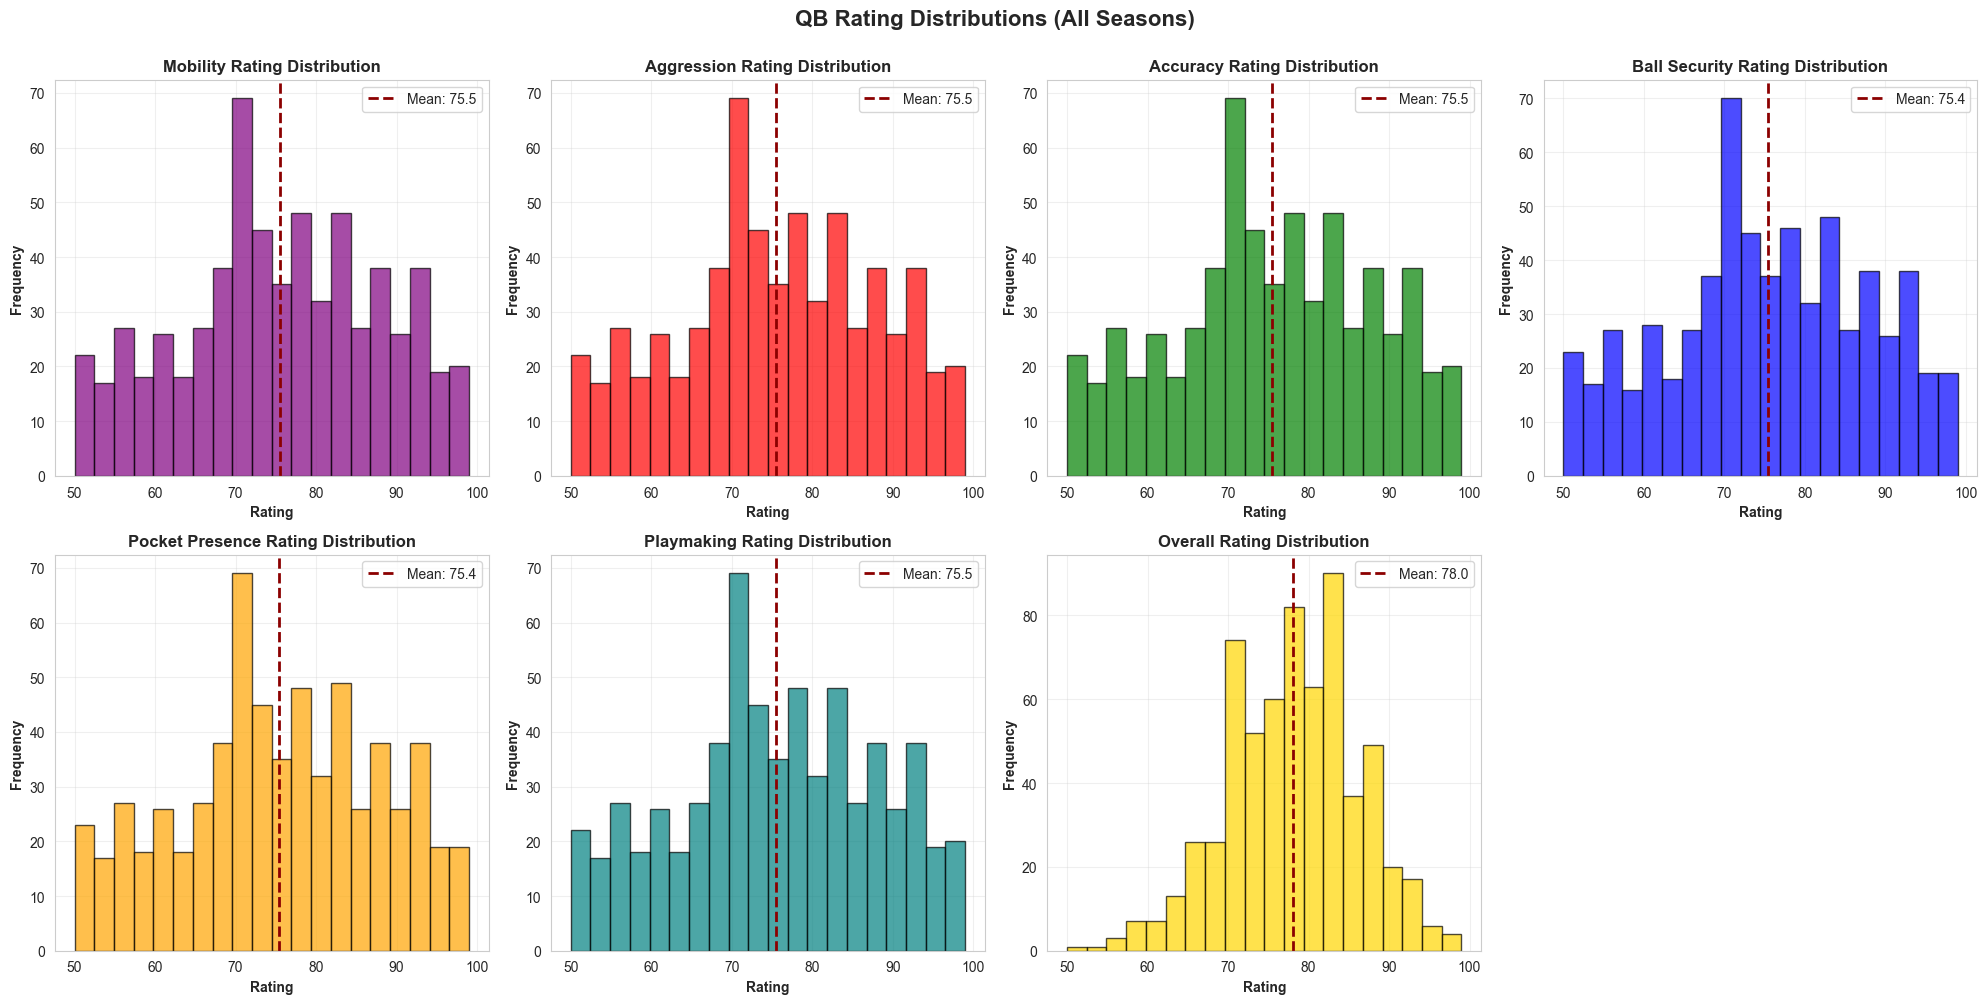

In [8]:
# Import visualization libraries (only when needed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Create rating distribution plots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

rating_cols = ['mobility_rating', 'aggression_rating', 'accuracy_rating', 
               'ball_security_rating', 'pocket_presence_rating', 'playmaking_rating', 'overall_rating']
titles = ['Mobility', 'Aggression', 'Accuracy', 'Ball Security', 'Pocket Presence', 'Playmaking', 'Overall']
colors = ['purple', 'red', 'green', 'blue', 'orange', 'teal', 'gold']

for idx, (col, title, color) in enumerate(zip(rating_cols, titles, colors)):
    ax = axes[idx]
    
    # Histogram
    ax.hist(rated_df[col], bins=20, color=color, alpha=0.7, edgecolor='black')
    
    # Add mean line
    mean_val = rated_df[col].mean()
    ax.axvline(mean_val, color='darkred', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_val:.1f}')
    
    ax.set_xlabel('Rating', fontweight='bold')
    ax.set_ylabel('Frequency', fontweight='bold')
    ax.set_title(f'{title} Rating Distribution', fontweight='bold', fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)

# Hide the extra subplot
axes[7].axis('off')

plt.suptitle('QB Rating Distributions (All Seasons)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Compare Specific QBs

In [9]:
# Import visualization library
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Select QBs to compare
QB_NAMES = ['P.Mahomes', 'L.Jackson', 'J.Allen', 'J.Burrow', 'J.Herbert']
COMPARE_SEASON = 2024

compare_data = rated_df[
    (rated_df['season'] == COMPARE_SEASON) & 
    (rated_df['passer_player_name'].isin(QB_NAMES))
].copy()

if len(compare_data) > 0:
    # Define categories and colors
    categories = ['Mobility', 'Aggression', 'Accuracy', 'Ball Security', 'Pocket Presence', 'Playmaking']
    
    # Color scheme based on traditional archetype categories
    archetype_colors = {
        'Mobile Playmaker': '#9D4EDD',      # Purple
        'Deep Threat': '#E63946',           # Red
        'Efficient Passer': '#F77F00',      # Orange
        'Ball Protector': '#06AED5',        # Blue
        'Quick-Release Specialist': '#2A9D8F'  # Teal
    }
    
    # Create subplots
    num_qbs = len(compare_data)
    cols = 3
    rows = (num_qbs + cols - 1) // cols
    
    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=[f"{row['passer_player_name']} - {row['archetype']}<br>(OVR: {row['overall_rating']})" 
                       for _, row in compare_data.iterrows()],
        specs=[[{'type': 'polar'}] * cols for _ in range(rows)]
    )
    
    # Add traces for each QB
    for idx, (_, qb) in enumerate(compare_data.iterrows()):
        row_pos = idx // cols + 1
        col_pos = idx % cols + 1
        
        values = [
            qb['mobility_rating'],
            qb['aggression_rating'],
            qb['accuracy_rating'],
            qb['ball_security_rating'],
            qb['pocket_presence_rating'],
            qb['playmaking_rating']
        ]
        
        # Close the radar chart
        values_closed = values + [values[0]]
        categories_closed = categories + [categories[0]]
        
        # Get color based on traditional primary archetype for consistency
        color = archetype_colors.get(qb['traditional_primary'], '#7f7f7f')
        
        fig.add_trace(
            go.Scatterpolar(
                r=values_closed,
                theta=categories_closed,
                fill='toself',
                line_color=color,
                fillcolor=color,
                opacity=0.6,
                name=qb['passer_player_name'],
                showlegend=False
            ),
            row=row_pos, col=col_pos
        )
    
    # Update layout for each subplot
    for i in range(1, num_qbs + 1):
        fig.update_polars(
            radialaxis=dict(
                visible=True,
                range=[50, 99],
                showticklabels=True,
                tickmode='array',
                tickvals=[60, 70, 80, 90],
                tickfont=dict(size=9)
            ),
            row=(i - 1) // cols + 1,
            col=(i - 1) % cols + 1
        )
    
    # Update overall layout
    fig.update_layout(
        title_text=f"QB Comparison - {COMPARE_SEASON} Season (Madden-Style Ratings)<br><sub>Showing Unique Archetype Classifications</sub>",
        title_font_size=18,
        height=400 * rows,
        showlegend=False
    )
    
    fig.show()
else:
    print(f"No data found for selected QBs in {COMPARE_SEASON}")

## Export Ratings

In [10]:
# Export ratings to CSV
export_cols = [
    'passer_player_name', 'season', 'pass_attempts',
    'overall_rating', 
    'mobility_rating', 'aggression_rating', 'accuracy_rating', 
    'ball_security_rating', 'pocket_presence_rating', 'playmaking_rating',
    # Unique archetype classification
    'archetype',
    # Traditional archetype categories for reference
    'traditional_primary', 'traditional_secondary',
    # Include raw stats for reference
    'mobility_raw', 'aggression_raw', 'accuracy_raw', 'turnover_rate', 'sack_rate', 'playmaking_raw'
]

# Only keep columns that exist in rated_df
export_cols = [col for col in export_cols if col in rated_df.columns]

rated_df[export_cols].to_csv('qb_madden_ratings.csv', index=False)

print("✅ Ratings exported to: qb_madden_ratings.csv")
print(f"   Total QB-seasons: {len(rated_df)}")
print(f"   Seasons covered: {sorted(rated_df['season'].unique())}")
print(f"   Unique Archetypes: {rated_df['archetype'].nunique()}")
print(f"\nMost common archetypes:")
print(rated_df['archetype'].value_counts().head(10))

✅ Ratings exported to: qb_madden_ratings.csv
   Total QB-seasons: 638
   Seasons covered: [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
   Unique Archetypes: 17

Most common archetypes:
archetype
Mobile Playmaker      105
Poised Passer          86
Dynamic Rusher         72
Pressure Resistant     65
Accurate Passer        46
Safe Ball Handler      45
Precision Passer       42
Ball Protector         39
Aggressive Passer      32
Gunslinger             29
Name: count, dtype: int64


## Rating Tiers

Define rating tiers like Madden does:

In [11]:
def get_tier(rating):
    """Assign tier based on rating."""
    if rating >= 95:
        return 'Superstar (95-99)'
    elif rating >= 90:
        return 'Elite (90-94)'
    elif rating >= 85:
        return 'Great (85-89)'
    elif rating >= 80:
        return 'Good Starter (80-84)'
    elif rating >= 75:
        return 'Average Starter (75-79)'
    elif rating >= 70:
        return 'Below Average (70-74)'
    else:
        return 'Backup (50-69)'

rated_df['tier'] = rated_df['overall_rating'].apply(get_tier)

print("\n" + "="*80)
print("OVERALL RATING TIER DISTRIBUTION (All Seasons)")
print("="*80)
tier_counts = rated_df['tier'].value_counts().sort_index(key=lambda x: x.map({
    'Superstar (95-99)': 7,
    'Elite (90-94)': 6,
    'Great (85-89)': 5,
    'Good Starter (80-84)': 4,
    'Average Starter (75-79)': 3,
    'Below Average (70-74)': 2,
    'Backup (50-69)': 1
}), ascending=False)

for tier, count in tier_counts.items():
    pct = 100 * count / len(rated_df)
    print(f"{tier:<30} {count:>4} QBs ({pct:>5.1f}%)")

print("\nThis distribution ensures most QBs fall in 70-85 range (realistic for Madden)")


OVERALL RATING TIER DISTRIBUTION (All Seasons)
Superstar (95-99)                10 QBs (  1.6%)
Elite (90-94)                    37 QBs (  5.8%)
Great (85-89)                    86 QBs ( 13.5%)
Good Starter (80-84)            153 QBs ( 24.0%)
Average Starter (75-79)         142 QBs ( 22.3%)
Below Average (70-74)           126 QBs ( 19.7%)
Backup (50-69)                   84 QBs ( 13.2%)

This distribution ensures most QBs fall in 70-85 range (realistic for Madden)


## Player Career Radar Chart (Tab 2)

This section allows you to select a player and view their Madden-style ratings as a radar chart for each season of their career.

In [ ]:
# Player Career Radar Chart
import plotly.graph_objects as go

# List of unique player names
player_names = sorted(rated_df['passer_player_name'].unique())

# Example: Select a player (replace with any name from player_names)
selected_player = player_names[0]  # Or set to a specific player, e.g., 'P.Mahomes'

player_data = rated_df[rated_df['passer_player_name'] == selected_player].sort_values('season')

if len(player_data) == 0:
    print(f"No data for {selected_player}.")
else:
    for _, row in player_data.iterrows():
        values = [row[col] for col in ['mobility_rating', 'aggression_rating', 'accuracy_rating', 'ball_security_rating', 'pocket_presence_rating', 'playmaking_rating']]
        values += [values[0]]
        labels_closed = ['Mobility', 'Aggression', 'Accuracy', 'Ball Security', 'Pocket Presence', 'Playmaking', 'Mobility']
        fig = go.Figure()
        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=labels_closed,
            fill='toself',
            name=f"{row['season']}"
        ))
        fig.update_layout(
            polar=dict(radialaxis=dict(visible=True, range=[50, 99])),
            showlegend=False,
            title=f"{selected_player} - {row['season']} ({row['archetype']}) - OVR: {row['overall_rating']}"
        )
        fig.show()